In [ ]:
# Importing libraries.
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# 1.0 Load dataset and Transformations

In [ ]:
# Mounting G-Drive to get your dataset.
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Performing Image Transformations.
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, ColorJitter
#[0,1]
train_transform = transforms.Compose([
    RandomRotation(degrees=15),  # Random rotation with a range of -15 to +15 degrees
    RandomHorizontalFlip(),     # Random horizontal flip with a 50% chance
    # ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Random changes in brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])




In [ ]:
train_dataset = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform_test, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Checking the dataset training size.
# dataset = ImageFolder(data_dir, transform=train_transform)
# print('Size of training dataset :', len(dataset))
# Viewing one of images shape.
img, label = train_dataset[100]
print(img.shape)

torch.Size([3, 32, 32])


In [ ]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))


Label:  frog (6)


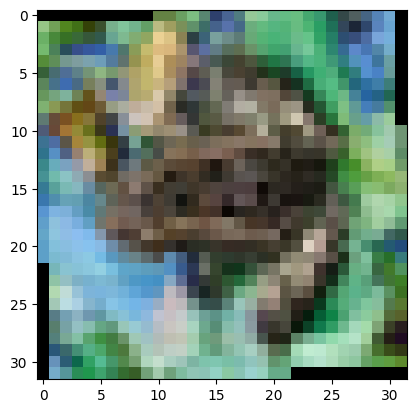

In [ ]:
show_image(*train_dataset[200])

In [ ]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = 10000
train_size = len(train_dataset) - val_size


In [ ]:
# Random Splitting and ensure each class is evenly distributed in teh random split.
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds), len(test_dataset)

(40000, 10000, 10000)

In [ ]:
from torch.utils.data import random_split, Subset
torch.manual_seed(10)
def stratified_split(dataset, class_labels, train_percent=0.8, val_percent=0.2):


    # base on the class to classify
    class_to_indices = {c: [] for c in set(class_labels)}
    for idx, label in enumerate(class_labels):
        class_to_indices[label].append(idx)

    train_indices, val_indices = [], []

    # for each class，split according to the rate
    for indices in class_to_indices.values():
        total_count = len(indices)
        train_count = int(total_count * train_percent)
        val_count = int(total_count * val_percent)

        indices = np.random.permutation(indices)
        train_indices.extend(indices[:train_count])
        val_indices.extend(indices[train_count:train_count+val_count])


    return Subset(dataset, train_indices), Subset(dataset, val_indices)



In [ ]:
class_labels = train_dataset.targets

train_ds, val_ds = stratified_split(train_dataset, class_labels)
len(train_ds), len(val_ds)

(40000, 10000)

In [ ]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [ ]:
# def accuracy(output, target, topk=(1,)):
#     """
#     Computes the accuracy over the k top predictions for the specified values of k
#     """
#     with torch.no_grad():
#         maxk = max(topk)  # Get the maximum value in topk
#         batch_size = target.size(0)

#         _, pred = output.topk(maxk, 1, True, True)
#         pred = pred.t()

#         correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)

#         res = {}
#         for k in topk:
#             correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
#             accuracy_k = correct_k.mul_(100.0 / batch_size)
#             res[k] = accuracy_k.item()  # Store accuracy as a percentage

#         return res  # Return a dictionary of accuracies for each k in topk

# def accuracy(output, target, topk=(1,)):
#     """
#     Computes the accuracy over the k top predictions for the specified values of k
#     In top-3 accuracy you give yourself credit for having the right answer
#     if the right answer appears in your top five guesses.
#     """
#     with torch.no_grad():
#         maxk = 3
#         batch_size = target.size(0)

#         # st()
#         _, pred = output.topk(maxk, 1, True, True)
#         pred = pred.t()
#         # st()
#         # correct = pred.eq(target.view(1, -1).expand_as(pred))
#         # correct = (pred == target.view(1, -1).expand_as(pred))
#         correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



#         correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

#         return correct_3.mul_(1.0 / batch_size)


# def accuracy(outputs, labels, topk=(1,)):

#    _, preds = torch.max(outputs, dim=1)
#    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def compute_accuracy(outputs, labels, topk=(1,)):
   _, preds = torch.max(outputs, dim=1)
   return torch.tensor(torch.sum(preds == labels).item() / len(preds))


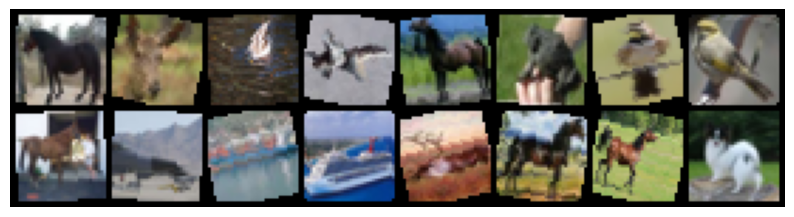

In [ ]:
# Multiple images preview.
# Get the first batch of images and labels
images, labels = next(iter(train_loader))
# Select a subset of images to display
images_to_display = images[:16]

# Creating the grid of images
grid = make_grid(images_to_display, nrow=8)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

# 2.0 CNN


## 2.1 Loss function

In [ ]:
# # cross_entropy
# class ImageClassificationBase(nn.Module):
#     def training_step(self, batch):
#         images, labels = batch
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
#         return loss

#     def validation_step(self, batch):
#         images, labels = batch
#         out = self(images)                    # Generate predictions
#         loss = F.cross_entropy(out, labels)   # Calculate loss
#         acc = accuracy(out, labels, (5))           # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# # Focal Loss
# class ImageClassificationFocalLoss(nn.Module):
#     def __init__(self, alpha=0.5, gamma=2.0):
#         super(ImageClassificationFocalLoss, self).__init__()
#         self.alpha = alpha  # Alpha parameter for Focal Loss
#         self.gamma = gamma  # Gamma parameter for Focal Loss

#     def focal_loss(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
#         return focal_loss.mean()

#     def training_step(self, batch):
#         images, labels = batch
#         out = self(images)  # Generate predictions
#         loss = self.focal_loss(out, labels)  # Calculate Focal Loss
#         return loss

#     def validation_step(self, batch):
#         images, labels = batch
#         out = self(images)  # Generate predictions
#         loss = self.focal_loss(out, labels)  # Calculate Focal Loss
#         acc = accuracy(out, labels, (5))  # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# # Smooth Loss
# class ImageClassificationSmoothLoss(nn.Module):
#     def __init__(self, smooth_factor=0.1):
#         super(ImageClassificationSmoothLoss, self).__init__()
#         self.smooth_factor = smooth_factor  # Smooth factor for Smooth Loss

#     def smooth_loss(self, inputs, targets):
#         num_classes = inputs.size(1)
#         smooth_labels = torch.full_like(inputs, self.smooth_factor / (num_classes - 1))
#         smooth_labels.scatter_(1, targets.unsqueeze(1), 1 - self.smooth_factor)

#         ce_loss = F.kl_div(F.log_softmax(inputs, dim=1), smooth_labels, reduction='batchmean')  # Smooth loss
#         return ce_loss.mean()

#     def training_step(self, batch):
#         images, labels = batch
#         out = self(images)  # Generate predictions
#         loss = self.smooth_loss(out, labels)  # Calculate Smooth Loss
#         return loss

#     def validation_step(self, batch):
#         images, labels = batch
#         out = self(images)  # Generate predictions
#         loss = self.smooth_loss(out, labels)  # Calculate Smooth Loss
#         acc = accuracy(out, labels, (5))  # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['val_acc']))



In [ ]:
# cross_entropy
# class ImageClassificationBase(nn.Module):
#     def training_step(self, batch):
#         images, labels = batch
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
#         return loss

#     def validation_step(self, batch):
#         images, labels = batch
#         out = self(images)                    # Generate predictions
#         loss = F.cross_entropy(out, labels)   # Calculate loss
#         acc = compute_accuracy(out, labels)           # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# # Focal Loss
# class ImageClassificationFocalLoss(nn.Module):
#     def __init__(self, alpha=0.5, gamma=2.0):
#         super(ImageClassificationFocalLoss, self).__init__()
#         self.alpha = alpha  # Alpha parameter for Focal Loss
#         self.gamma = gamma  # Gamma parameter for Focal Loss

#     def focal_loss(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-ce_loss)
#         focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
#         return focal_loss.mean()

#     def training_step(self, batch):
#         images, labels = batch
#         out = self(images)  # Generate predictions
#         loss = self.focal_loss(out, labels)  # Calculate Focal Loss
#         return loss

#     def validation_step(self, batch):
#         images, labels = batch
#         out = self(images)  # Generate predictions
#         loss = self.focal_loss(out, labels)  # Calculate Focal Loss
#         acc = compute_accuracy(out, labels)  # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['val_acc']))



# Smooth Loss
class ImageClassificationSmoothLoss(nn.Module):
    def __init__(self, smooth_factor=0.1):
        # super(ImageClassificationSmoothLoss, self).__init__()
        super().__init__()
        self.smooth_factor = smooth_factor  # Smooth factor for Smooth Loss

    def smooth_loss(self, inputs, targets):
        num_classes = inputs.size(1)
        smooth_labels = torch.full_like(inputs, self.smooth_factor / (num_classes - 1))
        smooth_labels.scatter_(1, targets.unsqueeze(1), 1 - self.smooth_factor)

        ce_loss = F.kl_div(F.log_softmax(inputs, dim=1), smooth_labels, reduction='batchmean')  # Smooth loss
        return ce_loss.mean()

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = self.smooth_loss(out, labels)  # Calculate Smooth Loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = self.smooth_loss(out, labels)  # Calculate Smooth Loss
        acc = compute_accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


## 2.2 Block

In [ ]:
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, dropout=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.LeakyReLU(0.1)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dropout = nn.Dropout(dropout)  # Added dropout layer

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)  # Applying dropout

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out



## 2.3 resnet18





In [ ]:
# # Input ->
#     # Initial Layers
#     [Conv7x7 -> BN -> LeakyReLU -> MaxPool] ->

#     # Layer 1: BasicBlock x 2
#     [Conv3x3 -> BN -> LeakyReLU -> Conv3x3 -> BN -> LeakyReLU -> Residual_Addition -> MaxPool] ->
#     [Conv3x3 -> BN -> LeakyReLU -> Conv3x3 -> BN -> LeakyReLU -> Residual_Addition -> MaxPool] ->

#     # Layer 2: BasicBlock x 2
#     [Conv3x3(stride=2) -> BN -> LeakyReLU -> Conv3x3 -> BN -> LeakyReLU -> Residual_Addition -> MaxPool] ->
#     [Conv3x3 -> BN -> LeakyReLU -> Conv3x3 -> BN -> LeakyReLU -> Residual_Addition -> MaxPool] ->

#     # Layer 3: BasicBlock x 2 (with Dropout)
#     [Conv3x3(stride=2) -> BN -> LeakyReLU -> Conv3x3 -> BN -> LeakyReLU -> Dropout -> Residual_Addition -> MaxPool] ->
#     [Conv3x3 -> BN -> LeakyReLU -> Conv3x3 -> BN -> LeakyReLU -> Dropout -> Residual_Addition -> MaxPool] ->

#     # Layer 4: BasicBlock x 2 (with Dropout)
#     [Conv3x3(stride=2) -> BN -> LeakyReLU -> Conv3x3 -> BN -> LeakyReLU -> Dropout -> Residual_Addition -> MaxPool] ->
#     [Conv3x3 -> BN -> LeakyReLU -> Conv3x3 -> BN -> LeakyReLU -> Dropout -> Residual_Addition -> MaxPool] ->

#     # Final Layers
#     AvgPool ->
#     Fully Connected ->
# # Output.


In [ ]:
class ConvolutionalNetworkSmoothLoss(ImageClassificationSmoothLoss):

    def __init__(self, block, layers, num_classes=10, dropout_probability=0.0):
        self.inplanes = 64
        super().__init__()
        self.dropout = nn.Dropout(dropout_probability)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU(0.1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout=dropout_probability)  # Added dropout
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout=dropout_probability)  # Added dropout

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, dropout=0.0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, dropout))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dropout(x)  # Applying dropout
        x = self.layer4(x)
        x = self.dropout(x)  # Applying dropout

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        X = self.fc(x)

        return X


def resnet18_SmoothLoss(dropout_probability=0):
    return ConvolutionalNetworkSmoothLoss(BasicBlock, [2, 2, 2, 2], num_classes=10, dropout_probability=dropout_probability)



In [ ]:
# class ConvolutionalNetwork(ImageClassificationBase):
#     def __init__(self, block, num_classes=10, dropout_probability=0):
#         self.inplanes = 3
#         super(ConvolutionalNetwork, self).__init__()
#         self.dropout = nn.Dropout(dropout_probability)

#         self.layer1 = self._make_layer(block, 64, stride=2)
#         self.layer2 = self._make_layer(block, 160, stride=2)
#         self.layer3 = self._make_layer(block, 320, stride=2, dropout=dropout_probability)  # Adding dropout
#         self.layer4 = self._make_layer(block, 640, stride=2, dropout=dropout_probability)  # Adding dropout

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(640 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#     def _make_layer(self, block, planes, stride=1, dropout=0.0):
#       downsample = None
#       if stride != 1 or self.inplanes != planes * block.expansion:
#           downsample = nn.Sequential(
#               nn.Conv2d(self.inplanes, planes * block.expansion,
#                         kernel_size=1, stride=stride, bias=False),  # Adjusted stride
#               nn.BatchNorm2d(planes * block.expansion),
#           )

#       layers = []
#       layers.append(block(self.inplanes, planes, stride, downsample, dropout))
#       self.inplanes = planes * block.expansion

#       return nn.Sequential(*layers)


#     def forward(self, X):
#         x = self.layer1(X)

#         x = self.layer2(x)

#         x = self.layer3(x)
#         x = self.dropout(x)  # Applying dropout
#         x = self.layer4(x)
#         x = self.dropout(x)  # Applying dropout

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         X = self.fc(x)

#         return F.log_softmax(X, dim=1)

# def resnet12_base(dropout_pro):
#     return ConvolutionalNetwork(BasicBlock, num_classes=10, dropout_probability=dropout_pro)


# class ConvolutionalNetworkFocalLoss(ImageClassificationFocalLoss):
#     def __init__(self, block, num_classes=10, dropout_probability=0):
#         self.inplanes = 3
#         super(ConvolutionalNetworkFocalLoss, self).__init__()
#         self.dropout = nn.Dropout(dropout_probability)

#         self.layer1 = self._make_layer(block, 64, stride=2)
#         self.layer2 = self._make_layer(block, 160, stride=2)
#         self.layer3 = self._make_layer(block, 320, stride=2, dropout=dropout_probability)
#         self.layer4 = self._make_layer(block, 640, stride=2, dropout=dropout_probability)

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(640 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#     def _make_layer(self, block, planes, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes * block.expansion,
#                           kernel_size=1, stride=1, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion

#         return nn.Sequential(*layers)

#     def forward(self, X):
#         x = self.layer1(X)

#         x = self.layer2(x)

#         x = self.layer3(x)
#         x = self.dropout(x)  # Applying dropout
#         x = self.layer4(x)
#         x = self.dropout(x)  # Applying dropout

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         X = self.fc(x)

#         return X


# def resnet12_FocalLoss(dropout_pro):
#     return ConvolutionalNetworkFocalLoss(BasicBlock, num_classes=10, dropout_probability=dropout_pro)




# class ConvolutionalNetworkSmoothLoss(ImageClassificationSmoothLoss):
#     def __init__(self, block, num_classes=10, dropout_probability = 0 ):
#         super().__init__()
#         # super(ConvolutionalNetworkSmoothLoss, self).__init__()
#         self.inplanes = 3
#         self.dropout = nn.Dropout(dropout_probability)
#         self.layer1 = self._make_layer(block, 64, stride=2)
#         self.layer2 = self._make_layer(block, 160, stride=2)
#         self.layer3 = self._make_layer(block, 320, stride=2)
#         self.layer4 = self._make_layer(block, 640, stride=2)

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(640 * block.expansion, num_classes)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#     def _make_layer(self, block, planes, stride=1):
#         downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, planes * block.expansion,
#                           kernel_size=1, stride=1, bias=False),
#                 nn.BatchNorm2d(planes * block.expansion),
#             )

#         layers = []
#         layers.append(block(self.inplanes, planes, stride, downsample))
#         self.inplanes = planes * block.expansion

#         return nn.Sequential(*layers)

#     def forward(self, X):
#         x = self.layer1(X)

#         x = self.layer2(x)

#         x = self.layer3(x)

#         x = self.layer4(x)


#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         X = self.fc(x)

#         return X



# def resnet12_SmoothLoss(dropout_pro):
#     return ConvolutionalNetworkSmoothLoss(BasicBlock, num_classes=10, dropout_probability=dropout_pro)

# 3.0 Funcitons


In [ ]:
# To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## 3.1 Training funtion

In [ ]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
device

device(type='cuda')

In [ ]:
input_size = 3*32*32
output_size = 10

In [ ]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

lr_gamma = 0.1
def fit(epochs, lr, model, train_loader, val_loader, optimizer_class=torch.optim.SGD, patience=7, l2=0.005):
    history = []
    if optimizer_class == torch.optim.Adam:
        optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=l2)
    else:
        optimizer = optimizer_class(model.parameters(), lr=lr, momentum=0.9, weight_decay=l2)

    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=lr_gamma)

    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        lr_scheduler.step()
        history.append(result)

        # Check for early stopping
        val_loss = result['val_loss']
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    return history

In [ ]:
def train_with_hyperparameters(loss_function, learning_rate, num_epochs, batch_size, dropout, optimizer_type, l2_weight=0.005):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Create the model with the specified dropout rate


    if loss_function == 'cross_entropy':
        model = resnet12_base(dropout).to(device)

    elif loss_function == 'focal_loss':
        model = resnet12_FocalLoss(dropout).to(device)


    elif loss_function == 'smooth_loss':
        model = resnet18_SmoothLoss(dropout).to(device)

    else:
        raise ValueError("Invalid loss function. Use 'cross_entropy', 'focal_loss', or 'smooth_loss'.")

    # Define the optimizer based on the optimizer_type parameter
    if optimizer_type == 'SGD':
        optimizer = torch.optim.SGD
    elif optimizer_type == 'Adam':
        optimizer = torch.optim.Adam
    elif optimizer_type == 'RMSprop':
        optimizer = torch.optim.RMSprop

    else:
        raise ValueError("Invalid optimizer type. Use 'SGD' or 'Adam' or 'RMSprop'.")


    # Create DataLoader objects with the specified batch size and move data to GPU
    train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

    device = get_default_device()
    train_loader = DeviceDataLoader(train_loader, device)
    val_loader = DeviceDataLoader(val_loader, device)
    test_loader = DeviceDataLoader(test_loader, device)

    # Train the model with the specified number of epochs
    # history = fit(num_epochs, learning_rate, model, train_loader, val_loader, optimizer)
    history = [evaluate(model, val_loader)]
    history += fit(num_epochs, learning_rate, model, train_loader, val_loader, optimizer, patience=5, l2=l2_weight)

    # Evaluate the model on the test set
    result = evaluate(model, test_loader)
    print(result)

    # Return the model and history
    return model, history

In [ ]:
# Check if GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Now, device will hold the correct device based on the availability of GPU
print("Selected device:", device)

Selected device: cuda


## 3.2 get results function

In [ ]:
# def get_best_combination(results):
#     last_accuracy = 0.0
#     last_epoch_combination = None

#     for i, (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight) in enumerate(results):
#         # Get the accuracy from the last epoch in the history
#         last_epoch_result = history[-1]  # Assuming that the last epoch's result is at the end of the history list
#         val_accuracy = last_epoch_result['val_acc']

#         # Check if the last epoch's accuracy is higher than the current highest accuracy
#         if val_accuracy > last_accuracy:
#             last_accuracy = val_accuracy
#             last_epoch_combination = (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, l2_weight)

#     return last_epoch_combination, last_accuracy


import heapq

def get_best_combinations(results, k):
    best_combinations = []

    # Sorting all the results based on the validation accuracy in descending order
    sorted_results = sorted(results, key=lambda x: x[-2][-1]['val_acc'], reverse=True)

    # Getting the top k results
    for i in range(min(k, len(sorted_results))):
        lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight = sorted_results[i]
        val_accuracy = history[-1]['val_acc']  # Getting the validation accuracy from the last epoch
        best_combinations.append(((lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, l2_weight), val_accuracy))

    return best_combinations



In [ ]:
def get_combinations(results, k):
    best_combinations = []

    # Sorting all the results based on the validation accuracy in descending order
    sorted_results = sorted(results, key=lambda x: x[-2][-1]['val_acc'], reverse=True)

    # Getting the top k results
    for i in range(min(k, len(sorted_results))):
        lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight = sorted_results[i]
        val_accuracy = history[-1]['val_acc']  # Getting the validation accuracy from the last epoch
        combination = (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight)
        best_combinations.append(combination)

    return best_combinations


In [ ]:
def list_combinations(results):
    for i, (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight) in enumerate(results):
        print(f"Combination {i+1}:")
        print(f"Learning Rate: {lr}")
        print(f"Number of Epochs: {num_epochs}")
        print(f"Batch Size: {batch_size}")
        print(f"Dropout Rate: {dropout}")
        print(f"Optimizer Type: {optimizer_type}")
        print(f"Loss Function: {loss_function}")
        print(f"L2 Weight: {l2_weight}")



        # Get the final accuracy and loss from the history
        final_accuracy = history[-1]['val_acc']
        final_loss = history[-1]['val_loss']

        print(f"Final Validation Accuracy: {final_accuracy:.2f}")
        print(f"Final Validation Loss: {final_loss:.4f}")
        print("-----------------------------------------------------")



In [ ]:
def plot_losses(results):
    markers = ['x', 'o', 's', '^', 'v', 'D', 'p']
    for i, (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight) in enumerate(results):
        train_losses = [x.get('train_loss') for x in history]
        val_losses = [x['val_loss'] for x in history]
        color = plt.cm.jet(float(i) / len(results))  # Assign different colors based on a colormap
        marker = markers[i % len(markers)]  # Cycle through marker styles for each combination
        plt.plot(train_losses, color=color, marker=marker, label=f"Combination {i+1}: lr={lr}, dropout={dropout}, optimizer={optimizer_type}, loss={loss_function} - Training Loss")
        plt.plot(val_losses, color=color, marker=marker, linestyle='dashed', label=f"Combination {i+1}: lr={lr}, dropout={dropout}, optimizer={optimizer_type}, loss={loss_function} - Validation Loss")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)  # Place legend at the bottom center and in two columns
    plt.rcParams["figure.figsize"] = (15, 10)  # Set figure size
    plt.show()

In [ ]:
def plot_accuracies(results):
    plt.figure(figsize=(12, 7))
    for i, (lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight) in enumerate(results):
        accuracies = [x['val_acc'] for x in history]
        plt.plot(accuracies, '-x', label=f"Model {i+1}: LR={lr}, Epochs={num_epochs}, Batch size={batch_size}, Dropout={dropout}, Optimizer={optimizer_type}, Loss={loss_function}")

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy vs. Epochs for Different Models')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # Place legend at the bottom center and in two columns
    plt.grid(True)
    plt.show()



# 4.0 Train

## 4.1 Resnet18 without l2 and dropout

Find the best learning rate for this resnet architecture

In [ ]:
# Params: (0.001, 30, 64, 0, 'Adam', 'smooth_loss', 0), Accuracy: 0.8789808750152588
# Params: (0.01, 30, 64, 0, 'Adam', 'smooth_loss', 0), Accuracy: 0.8743033409118652
# Params: (0.01, 30, 64, 0, 'SGD', 'smooth_loss', 0), Accuracy: 0.8697253465652466

In [ ]:
learning_rates = [0.1, 0.01, 0.001]
num_epochs = 30
batch_size = 64
l2_weight = 0
dropout_rates = 0
dropout = 0
optimizer_types = ['Adam']
loss_functions = ['smooth_loss']
# loss_functions = ['cross_entropy', 'focal_loss', 'smooth_loss']
# 'SGD', 'Adam', 'RMSprop'
# Initialize a list to store the results
results2_1 = []
num_classes = 10
lr_gamma = 1 #not change lr

# Loop over all combinations of hyperparameters
for lr in learning_rates:
                for optimizer_type in optimizer_types:
                    for loss_function in loss_functions:
                        print(f"Training with lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}, dropout={dropout}, optimizer={optimizer_type}, loss_function={loss_function}, L2_weight={l2_weight}")
                        # Train the model with the current hyperparameters
                        # Example of calling the function
                        model, history = train_with_hyperparameters(loss_function, lr, num_epochs, batch_size, dropout, optimizer_type, l2_weight)

                        # Store the results2
                        results2_1.append((lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight))

Training with lr=0.1, num_epochs=30, batch_size=64, dropout=0, optimizer=Adam, loss_function=smooth_loss, L2_weight=0


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.7812, val_loss: 1.3218, val_acc: 0.3707


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.3055, val_loss: 1.3805, val_acc: 0.3855


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.2962, val_loss: 1.3021, val_acc: 0.4563


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.2330, val_loss: 4.3919, val_acc: 0.4304


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.2163, val_loss: 1.8447, val_acc: 0.4989


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.1909, val_loss: 1.4053, val_acc: 0.4085


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.3773, val_loss: 2.5969, val_acc: 0.4253


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.1991, val_loss: 1.0242, val_acc: 0.5532


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.0919, val_loss: 1.8421, val_acc: 0.4812


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.0501, val_loss: 0.9802, val_acc: 0.5910


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.9568, val_loss: 1.3511, val_acc: 0.4415


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.9035, val_loss: 1.0303, val_acc: 0.5473


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.0670, val_loss: 5.9083, val_acc: 0.3395


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.0327, val_loss: 0.9589, val_acc: 0.6110


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.9086, val_loss: 0.8987, val_acc: 0.6171


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.8633, val_loss: 0.7944, val_acc: 0.6521


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.9813, val_loss: 1.3477, val_acc: 0.4632


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.1272, val_loss: 0.9175, val_acc: 0.6255


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.9439, val_loss: 0.8190, val_acc: 0.6425


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.8551, val_loss: 1.2220, val_acc: 0.5131


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.8710, val_loss: 0.8103, val_acc: 0.6553
Early stopping triggered.
{'val_loss': 0.7948389053344727, 'val_acc': 0.6678941249847412}
Training with lr=0.01, num_epochs=30, batch_size=64, dropout=0, optimizer=Adam, loss_function=smooth_loss, L2_weight=0


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.4184, val_loss: 1.3465, val_acc: 0.3877


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.0459, val_loss: 1.1900, val_acc: 0.4461


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.9146, val_loss: 0.9561, val_acc: 0.5523


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8163, val_loss: 1.0858, val_acc: 0.5339


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7433, val_loss: 0.7606, val_acc: 0.6600


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6955, val_loss: 0.7071, val_acc: 0.6731


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6556, val_loss: 0.8362, val_acc: 0.6272


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6187, val_loss: 0.7297, val_acc: 0.6723


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.5835, val_loss: 0.8118, val_acc: 0.6320


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.5581, val_loss: 0.7841, val_acc: 0.6534


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.5318, val_loss: 0.6029, val_acc: 0.7302


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5045, val_loss: 0.6494, val_acc: 0.7101


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4921, val_loss: 0.7408, val_acc: 0.6727


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4696, val_loss: 0.6073, val_acc: 0.7350


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4515, val_loss: 0.6022, val_acc: 0.7344


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4337, val_loss: 0.5806, val_acc: 0.7431


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4144, val_loss: 0.5693, val_acc: 0.7468


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.3980, val_loss: 0.5744, val_acc: 0.7417


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.3848, val_loss: 0.5741, val_acc: 0.7493


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.3704, val_loss: 0.5884, val_acc: 0.7412


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.3549, val_loss: 0.5573, val_acc: 0.7533


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.3383, val_loss: 0.6299, val_acc: 0.7334


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.3266, val_loss: 0.6136, val_acc: 0.7352


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.3132, val_loss: 0.5890, val_acc: 0.7516


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.3023, val_loss: 0.6133, val_acc: 0.7381


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.2896, val_loss: 0.5522, val_acc: 0.7659


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.2771, val_loss: 0.5797, val_acc: 0.7597


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.2651, val_loss: 0.5632, val_acc: 0.7668


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.2599, val_loss: 0.5574, val_acc: 0.7697


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.2503, val_loss: 0.5759, val_acc: 0.7630
{'val_loss': 0.5325989723205566, 'val_acc': 0.7760748267173767}
Training with lr=0.001, num_epochs=30, batch_size=64, dropout=0, optimizer=Adam, loss_function=smooth_loss, L2_weight=0


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.1709, val_loss: 1.2683, val_acc: 0.4283


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9156, val_loss: 1.5056, val_acc: 0.3930


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7984, val_loss: 0.9167, val_acc: 0.5821


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7194, val_loss: 0.7831, val_acc: 0.6472


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6644, val_loss: 0.7516, val_acc: 0.6614


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6190, val_loss: 0.7352, val_acc: 0.6702


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.5827, val_loss: 0.7783, val_acc: 0.6615


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.5533, val_loss: 0.6140, val_acc: 0.7276


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.5209, val_loss: 0.6433, val_acc: 0.7148


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.4966, val_loss: 0.8109, val_acc: 0.6479


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4694, val_loss: 0.5961, val_acc: 0.7341


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4479, val_loss: 0.6062, val_acc: 0.7268


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4294, val_loss: 0.5997, val_acc: 0.7347


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4081, val_loss: 0.6271, val_acc: 0.7266


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.3892, val_loss: 0.5366, val_acc: 0.7620


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.3696, val_loss: 0.6677, val_acc: 0.7113


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.3559, val_loss: 0.5462, val_acc: 0.7626


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.3396, val_loss: 0.5988, val_acc: 0.7340


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.3207, val_loss: 0.5357, val_acc: 0.7682


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.3072, val_loss: 0.5318, val_acc: 0.7721


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.2951, val_loss: 0.5259, val_acc: 0.7768


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.2794, val_loss: 0.5489, val_acc: 0.7657


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.2645, val_loss: 0.5066, val_acc: 0.7839


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.2548, val_loss: 0.5822, val_acc: 0.7543


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.2431, val_loss: 0.6051, val_acc: 0.7487


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.2358, val_loss: 0.5378, val_acc: 0.7756


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.2218, val_loss: 0.5195, val_acc: 0.7831


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.2117, val_loss: 0.5453, val_acc: 0.7765
Early stopping triggered.
{'val_loss': 0.49652019143104553, 'val_acc': 0.793292224407196}


In [ ]:
objects_to_save_results2_1 = results2_1
# Save all the objects
with open('/content/drive/MyDrive/Colab Notebooks/deep learning fundamentals/assignment2/object_to_save/objects_to_save_results2_1.pkl', 'wb') as f:
    pickle.dump(objects_to_save_results2_1, f)


In [ ]:
best_combinations1 = get_best_combinations(results2_1, k=1)

# Printing the results
for params, accuracy in best_combinations1:
    print(f"Params: {params}, Accuracy: {accuracy}")

Params: (0.001, 30, 64, 0, 'Adam', 'smooth_loss', 0), Accuracy: 0.7764729261398315
Params: (0.01, 30, 64, 0, 'Adam', 'smooth_loss', 0), Accuracy: 0.7630374431610107
Params: (0.1, 30, 64, 0, 'Adam', 'smooth_loss', 0), Accuracy: 0.6552547812461853


## 4.2 Resnet18 train with regularizaiton

In [ ]:
learning_rates = [0.01, 0.001]
num_epochs = 30
batch_size = 64
l2_weight_list = [0, 0.001, 0.0005]
dropout_rates = [0, 0.2, 0.5]
optimizer_types = ['Adam']
loss_functions = ['smooth_loss']
# loss_functions = ['cross_entropy', 'focal_loss', 'smooth_loss']
# 'SGD', 'Adam', 'RMSprop'
# Initialize a list to store the results
results2_2 = []
num_classes = 10
lr_gamma = 1 #not change lr

# Loop over all combinations of hyperparameters
for lr in learning_rates:
    for l2_weight in l2_weight_list:
            for dropout in dropout_rates:
                for optimizer_type in optimizer_types:
                    for loss_function in loss_functions:
                        print(f"Training with lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}, dropout={dropout}, optimizer={optimizer_type}, loss_function={loss_function}, L2_weight={l2_weight}")
                        # Train the model with the current hyperparameters
                        # Example of calling the function
                        model, history = train_with_hyperparameters(loss_function, lr, num_epochs, batch_size, dropout, optimizer_type, l2_weight)

                        # Store the results2
                        results2_2.append((lr, num_epochs, batch_size, dropout, optimizer_type, loss_function, model, history, l2_weight))


Training with lr=0.01, num_epochs=30, batch_size=64, dropout=0, optimizer=Adam, loss_function=smooth_loss, L2_weight=0


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.3889, val_loss: 1.4885, val_acc: 0.3468


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.0614, val_loss: 1.3420, val_acc: 0.4323


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.9251, val_loss: 0.8947, val_acc: 0.5929


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8224, val_loss: 1.0119, val_acc: 0.5442


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7557, val_loss: 0.9588, val_acc: 0.5806


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6958, val_loss: 0.7276, val_acc: 0.6686


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6553, val_loss: 0.8063, val_acc: 0.6383


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6174, val_loss: 0.6941, val_acc: 0.6846


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.5853, val_loss: 0.6149, val_acc: 0.7227


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.5545, val_loss: 0.6737, val_acc: 0.7011


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.5359, val_loss: 0.6133, val_acc: 0.7244


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5091, val_loss: 0.6214, val_acc: 0.7241


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4840, val_loss: 0.6035, val_acc: 0.7306


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4657, val_loss: 0.6570, val_acc: 0.7086


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4458, val_loss: 0.5846, val_acc: 0.7390


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4299, val_loss: 0.5359, val_acc: 0.7609


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4077, val_loss: 0.6390, val_acc: 0.7173


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.3950, val_loss: 0.6067, val_acc: 0.7316


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.3752, val_loss: 0.5568, val_acc: 0.7549


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.3605, val_loss: 0.5480, val_acc: 0.7585


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.3483, val_loss: 0.6103, val_acc: 0.7361
Early stopping triggered.
{'val_loss': 0.5575571060180664, 'val_acc': 0.7576631903648376}
Training with lr=0.01, num_epochs=30, batch_size=64, dropout=0.2, optimizer=Adam, loss_function=smooth_loss, L2_weight=0


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.5249, val_loss: 1.2123, val_acc: 0.4249


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.1660, val_loss: 1.1339, val_acc: 0.4704


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.0537, val_loss: 1.0925, val_acc: 0.5250


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.9622, val_loss: 1.0035, val_acc: 0.5889


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.8790, val_loss: 0.8979, val_acc: 0.5973


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.8031, val_loss: 0.8583, val_acc: 0.6155


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7530, val_loss: 0.7802, val_acc: 0.6476


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.7163, val_loss: 0.7028, val_acc: 0.6829


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6844, val_loss: 0.7595, val_acc: 0.6604


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6499, val_loss: 0.6860, val_acc: 0.6887


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6232, val_loss: 0.7742, val_acc: 0.6554


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5971, val_loss: 0.6365, val_acc: 0.7129


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.5758, val_loss: 0.7371, val_acc: 0.6758


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5576, val_loss: 0.6284, val_acc: 0.7241


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5321, val_loss: 0.6384, val_acc: 0.7133


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5130, val_loss: 0.6161, val_acc: 0.7210


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4953, val_loss: 0.6524, val_acc: 0.7095


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4781, val_loss: 0.5740, val_acc: 0.7446


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4593, val_loss: 0.5720, val_acc: 0.7454


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4419, val_loss: 0.6703, val_acc: 0.7044


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.4220, val_loss: 0.5697, val_acc: 0.7501


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.4167, val_loss: 0.5812, val_acc: 0.7396


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.3980, val_loss: 0.5816, val_acc: 0.7484


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.3825, val_loss: 0.6288, val_acc: 0.7303


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.3688, val_loss: 0.5820, val_acc: 0.7526


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.3614, val_loss: 0.6169, val_acc: 0.7368
Early stopping triggered.
{'val_loss': 0.5562533140182495, 'val_acc': 0.7602508068084717}
Training with lr=0.01, num_epochs=30, batch_size=64, dropout=0.5, optimizer=Adam, loss_function=smooth_loss, L2_weight=0


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.9287, val_loss: 4.9941, val_acc: 0.1424


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.4120, val_loss: 1.3061, val_acc: 0.3897


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.2431, val_loss: 1.6355, val_acc: 0.3367


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.1551, val_loss: 1.0677, val_acc: 0.5026


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.0809, val_loss: 1.0037, val_acc: 0.5488


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.0272, val_loss: 0.9893, val_acc: 0.5336


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.9509, val_loss: 1.0739, val_acc: 0.5310


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.9025, val_loss: 0.9974, val_acc: 0.5495


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.8622, val_loss: 0.9674, val_acc: 0.5699


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.8084, val_loss: 0.8254, val_acc: 0.6264


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.7737, val_loss: 0.7254, val_acc: 0.6737


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.7371, val_loss: 0.7180, val_acc: 0.6720


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.7091, val_loss: 0.7354, val_acc: 0.6671


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.6855, val_loss: 0.7515, val_acc: 0.6665


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.6591, val_loss: 0.7769, val_acc: 0.6575


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.6393, val_loss: 0.6852, val_acc: 0.7001


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.6120, val_loss: 0.6690, val_acc: 0.7057


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.5955, val_loss: 0.6874, val_acc: 0.6900


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.5847, val_loss: 0.6120, val_acc: 0.7254


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.5658, val_loss: 0.6727, val_acc: 0.7064


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.5475, val_loss: 0.6542, val_acc: 0.7081


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.5320, val_loss: 0.6626, val_acc: 0.7067


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.5185, val_loss: 0.6337, val_acc: 0.7257


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.5087, val_loss: 0.6021, val_acc: 0.7328


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4942, val_loss: 0.6002, val_acc: 0.7403


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.4775, val_loss: 0.5952, val_acc: 0.7368


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.4642, val_loss: 0.6247, val_acc: 0.7338


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4564, val_loss: 0.5970, val_acc: 0.7441


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4472, val_loss: 0.6243, val_acc: 0.7334


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4348, val_loss: 0.5825, val_acc: 0.7471
{'val_loss': 0.5430004000663757, 'val_acc': 0.7651273608207703}
Training with lr=0.01, num_epochs=30, batch_size=64, dropout=0, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.001


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.4255, val_loss: 1.5546, val_acc: 0.2906


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.1856, val_loss: 1.1592, val_acc: 0.4434


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.1223, val_loss: 1.3065, val_acc: 0.3942


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.0870, val_loss: 1.5179, val_acc: 0.3116


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.0638, val_loss: 1.1840, val_acc: 0.4436


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.0480, val_loss: 1.2908, val_acc: 0.4019


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.0353, val_loss: 1.5739, val_acc: 0.3130
Early stopping triggered.
{'val_loss': 1.4956737756729126, 'val_acc': 0.3335987329483032}
Training with lr=0.01, num_epochs=30, batch_size=64, dropout=0.2, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.001


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.5259, val_loss: 1.3063, val_acc: 0.3715


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.2523, val_loss: 1.3263, val_acc: 0.3624


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.2071, val_loss: 1.4061, val_acc: 0.3384


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.1870, val_loss: 1.3951, val_acc: 0.3479


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.1602, val_loss: 1.2614, val_acc: 0.3833


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.1464, val_loss: 1.3679, val_acc: 0.3425


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.1439, val_loss: 1.2182, val_acc: 0.4093


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.1320, val_loss: 1.1909, val_acc: 0.4262


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.1219, val_loss: 1.3430, val_acc: 0.3825


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.1162, val_loss: 1.1196, val_acc: 0.4813


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.1149, val_loss: 1.0962, val_acc: 0.4788


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.1062, val_loss: 1.2539, val_acc: 0.4083


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.1082, val_loss: 1.1845, val_acc: 0.4407


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.1103, val_loss: 1.4632, val_acc: 0.3139


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.1029, val_loss: 1.2153, val_acc: 0.4343


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.1035, val_loss: 1.1565, val_acc: 0.4510
Early stopping triggered.
{'val_loss': 1.1210390329360962, 'val_acc': 0.46745622158050537}
Training with lr=0.01, num_epochs=30, batch_size=64, dropout=0.5, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.001


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.7987, val_loss: 1.7226, val_acc: 0.2143


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.3641, val_loss: 1.2638, val_acc: 0.3847


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.3019, val_loss: 1.2465, val_acc: 0.3980


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.2818, val_loss: 1.3387, val_acc: 0.3583


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.2769, val_loss: 1.5868, val_acc: 0.2625


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.2609, val_loss: 1.4506, val_acc: 0.3163


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.2548, val_loss: 1.2857, val_acc: 0.3793


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.2463, val_loss: 1.3357, val_acc: 0.3503
Early stopping triggered.
{'val_loss': 1.3325320482254028, 'val_acc': 0.3550955355167389}
Training with lr=0.01, num_epochs=30, batch_size=64, dropout=0, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.0005


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.4378, val_loss: 1.6346, val_acc: 0.2572


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.1649, val_loss: 1.2342, val_acc: 0.4082


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.0909, val_loss: 1.2072, val_acc: 0.4458


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.0487, val_loss: 1.3147, val_acc: 0.3870


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.0167, val_loss: 1.0589, val_acc: 0.4984


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.9914, val_loss: 1.2998, val_acc: 0.3953


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.9765, val_loss: 1.2143, val_acc: 0.4340


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.9659, val_loss: 1.0143, val_acc: 0.5295


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.9595, val_loss: 1.0056, val_acc: 0.5262


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.9516, val_loss: 1.2582, val_acc: 0.4129


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.9400, val_loss: 1.0995, val_acc: 0.4873


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.9400, val_loss: 1.0093, val_acc: 0.5364


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.9352, val_loss: 1.6327, val_acc: 0.3342


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.9294, val_loss: 1.0207, val_acc: 0.5291
Early stopping triggered.
{'val_loss': 0.9940849542617798, 'val_acc': 0.5444864630699158}
Training with lr=0.01, num_epochs=30, batch_size=64, dropout=0.2, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.0005


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.5080, val_loss: 1.2208, val_acc: 0.4225


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.2295, val_loss: 1.3454, val_acc: 0.3770


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.1602, val_loss: 1.0972, val_acc: 0.4868


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.1255, val_loss: 1.1983, val_acc: 0.4244


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.0966, val_loss: 1.3657, val_acc: 0.3836


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.0740, val_loss: 1.6402, val_acc: 0.3634


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.0594, val_loss: 1.0094, val_acc: 0.5254


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.0487, val_loss: 1.1793, val_acc: 0.4521


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.0493, val_loss: 1.7313, val_acc: 0.2749


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.0414, val_loss: 1.2275, val_acc: 0.4515


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.0341, val_loss: 1.2036, val_acc: 0.4598


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.0243, val_loss: 1.0839, val_acc: 0.4928
Early stopping triggered.
{'val_loss': 1.0240558385849, 'val_acc': 0.5293591022491455}
Training with lr=0.01, num_epochs=30, batch_size=64, dropout=0.5, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.0005


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.8524, val_loss: 1.4318, val_acc: 0.2953


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.3494, val_loss: 1.5067, val_acc: 0.2697


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.2726, val_loss: 1.1594, val_acc: 0.4449


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.2336, val_loss: 1.2136, val_acc: 0.4258


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.2108, val_loss: 1.1496, val_acc: 0.4580


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.1936, val_loss: 1.1483, val_acc: 0.4573


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.1824, val_loss: 1.1811, val_acc: 0.4354


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.1777, val_loss: 1.4556, val_acc: 0.3740


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.1724, val_loss: 1.1993, val_acc: 0.4371


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.1679, val_loss: 1.0603, val_acc: 0.5007


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.1606, val_loss: 1.1151, val_acc: 0.4751


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.1611, val_loss: 1.2407, val_acc: 0.3993


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.1554, val_loss: 1.0916, val_acc: 0.4812


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.1580, val_loss: 1.1714, val_acc: 0.4244


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.1558, val_loss: 1.2178, val_acc: 0.4280
Early stopping triggered.
{'val_loss': 1.1623142957687378, 'val_acc': 0.46108677983283997}
Training with lr=0.001, num_epochs=30, batch_size=64, dropout=0, optimizer=Adam, loss_function=smooth_loss, L2_weight=0


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.1669, val_loss: 1.1033, val_acc: 0.4894


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.8989, val_loss: 0.8803, val_acc: 0.5840


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.7838, val_loss: 0.8678, val_acc: 0.6146


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7088, val_loss: 0.7487, val_acc: 0.6582


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6542, val_loss: 0.8385, val_acc: 0.6302


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6179, val_loss: 0.9887, val_acc: 0.5610


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.5795, val_loss: 0.6914, val_acc: 0.6912


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.5468, val_loss: 0.6252, val_acc: 0.7224


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.5195, val_loss: 0.6221, val_acc: 0.7223


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.4903, val_loss: 0.6149, val_acc: 0.7224


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4674, val_loss: 0.5343, val_acc: 0.7587


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4485, val_loss: 0.5706, val_acc: 0.7432


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4271, val_loss: 0.5699, val_acc: 0.7451


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4031, val_loss: 0.5630, val_acc: 0.7443


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.3877, val_loss: 0.5812, val_acc: 0.7349


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.3693, val_loss: 0.5893, val_acc: 0.7428
Early stopping triggered.
{'val_loss': 0.5260363817214966, 'val_acc': 0.7734872698783875}
Training with lr=0.001, num_epochs=30, batch_size=64, dropout=0.2, optimizer=Adam, loss_function=smooth_loss, L2_weight=0


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.2156, val_loss: 1.0188, val_acc: 0.5258


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9482, val_loss: 1.2131, val_acc: 0.4928


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.8299, val_loss: 0.8451, val_acc: 0.6109


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7511, val_loss: 0.7791, val_acc: 0.6426


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.6971, val_loss: 0.6791, val_acc: 0.6913


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6476, val_loss: 0.9556, val_acc: 0.5730


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6159, val_loss: 0.6966, val_acc: 0.6906


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.5831, val_loss: 0.6745, val_acc: 0.6966


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.5517, val_loss: 0.6103, val_acc: 0.7233


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.5248, val_loss: 0.6161, val_acc: 0.7238


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4993, val_loss: 0.6660, val_acc: 0.7094


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.4832, val_loss: 0.5540, val_acc: 0.7545


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.4604, val_loss: 0.7389, val_acc: 0.6744


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.4428, val_loss: 0.5515, val_acc: 0.7520


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4251, val_loss: 0.7597, val_acc: 0.6799


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4094, val_loss: 0.5629, val_acc: 0.7466


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.3899, val_loss: 0.5228, val_acc: 0.7646


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.3775, val_loss: 0.5599, val_acc: 0.7567


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.3599, val_loss: 0.5343, val_acc: 0.7685


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.3450, val_loss: 0.5914, val_acc: 0.7460


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.3340, val_loss: 0.5328, val_acc: 0.7686


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.3155, val_loss: 0.5347, val_acc: 0.7661
Early stopping triggered.
{'val_loss': 0.48363739252090454, 'val_acc': 0.7901074886322021}
Training with lr=0.001, num_epochs=30, batch_size=64, dropout=0.5, optimizer=Adam, loss_function=smooth_loss, L2_weight=0


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.3815, val_loss: 1.1657, val_acc: 0.4477


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.0593, val_loss: 0.9230, val_acc: 0.5605


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.9224, val_loss: 0.9474, val_acc: 0.5552


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8411, val_loss: 0.9189, val_acc: 0.5822


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7757, val_loss: 0.7389, val_acc: 0.6546


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7218, val_loss: 0.7703, val_acc: 0.6533


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6897, val_loss: 0.6904, val_acc: 0.6864


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6494, val_loss: 0.6249, val_acc: 0.7169


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6169, val_loss: 0.7502, val_acc: 0.6638


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.5864, val_loss: 0.7149, val_acc: 0.6848


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.5632, val_loss: 0.6304, val_acc: 0.7189


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5415, val_loss: 0.6198, val_acc: 0.7251


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.5233, val_loss: 0.5765, val_acc: 0.7379


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5008, val_loss: 0.6150, val_acc: 0.7251


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.4851, val_loss: 0.5332, val_acc: 0.7600


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.4686, val_loss: 0.5785, val_acc: 0.7466


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.4486, val_loss: 0.5225, val_acc: 0.7665


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.4318, val_loss: 0.5634, val_acc: 0.7520


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.4159, val_loss: 0.5742, val_acc: 0.7431


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.4098, val_loss: 0.6427, val_acc: 0.7266


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.3924, val_loss: 0.6672, val_acc: 0.7109


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.3750, val_loss: 0.5499, val_acc: 0.7597
Early stopping triggered.
{'val_loss': 0.4966106116771698, 'val_acc': 0.787619411945343}
Training with lr=0.001, num_epochs=30, batch_size=64, dropout=0, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.001


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.1688, val_loss: 1.0389, val_acc: 0.5131


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9304, val_loss: 0.9199, val_acc: 0.5694


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.8407, val_loss: 0.9218, val_acc: 0.5783


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7876, val_loss: 0.8639, val_acc: 0.5995


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7503, val_loss: 0.8630, val_acc: 0.6080


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7129, val_loss: 0.8137, val_acc: 0.6330


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6838, val_loss: 0.7229, val_acc: 0.6692


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6581, val_loss: 0.7654, val_acc: 0.6513


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6404, val_loss: 0.7350, val_acc: 0.6686


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6172, val_loss: 0.9301, val_acc: 0.5895


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6062, val_loss: 0.7044, val_acc: 0.6794


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5941, val_loss: 0.7763, val_acc: 0.6516


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.5842, val_loss: 0.7150, val_acc: 0.6742


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5791, val_loss: 0.6434, val_acc: 0.7044


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5619, val_loss: 0.6280, val_acc: 0.7159


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5607, val_loss: 0.6589, val_acc: 0.7026


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5451, val_loss: 0.6013, val_acc: 0.7271


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.5439, val_loss: 0.6684, val_acc: 0.6935


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.5377, val_loss: 0.8308, val_acc: 0.6327


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.5380, val_loss: 0.6565, val_acc: 0.7049


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.5326, val_loss: 0.6159, val_acc: 0.7200


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.5300, val_loss: 0.6805, val_acc: 0.6917
Early stopping triggered.
{'val_loss': 0.6093981266021729, 'val_acc': 0.7221337556838989}
Training with lr=0.001, num_epochs=30, batch_size=64, dropout=0.2, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.001


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.2094, val_loss: 1.2362, val_acc: 0.4185


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9572, val_loss: 1.1331, val_acc: 0.5030


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.8656, val_loss: 1.0051, val_acc: 0.5331


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8116, val_loss: 0.9232, val_acc: 0.5796


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7711, val_loss: 0.9913, val_acc: 0.5545


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7368, val_loss: 0.8097, val_acc: 0.6318


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7085, val_loss: 0.7733, val_acc: 0.6461


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6857, val_loss: 0.8792, val_acc: 0.6104


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6627, val_loss: 0.7594, val_acc: 0.6619


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6453, val_loss: 0.7881, val_acc: 0.6507


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6357, val_loss: 0.7074, val_acc: 0.6821


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6145, val_loss: 0.7190, val_acc: 0.6791


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6124, val_loss: 0.6776, val_acc: 0.6886


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.6010, val_loss: 0.6984, val_acc: 0.6881


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5835, val_loss: 0.6914, val_acc: 0.6927


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5866, val_loss: 0.7397, val_acc: 0.6700


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5760, val_loss: 1.0849, val_acc: 0.5539


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.5733, val_loss: 0.7457, val_acc: 0.6659
Early stopping triggered.
{'val_loss': 0.6817548274993896, 'val_acc': 0.6927746534347534}
Training with lr=0.001, num_epochs=30, batch_size=64, dropout=0.5, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.001


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.3711, val_loss: 1.7381, val_acc: 0.2567


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.0700, val_loss: 1.2943, val_acc: 0.4348


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.9572, val_loss: 1.0990, val_acc: 0.5171


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8941, val_loss: 1.0020, val_acc: 0.5449


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.8449, val_loss: 0.9760, val_acc: 0.5684


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.8045, val_loss: 0.9017, val_acc: 0.5900


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7748, val_loss: 0.7641, val_acc: 0.6595


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.7448, val_loss: 0.8763, val_acc: 0.6096


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.7208, val_loss: 0.8063, val_acc: 0.6395


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6970, val_loss: 0.8273, val_acc: 0.6407


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6836, val_loss: 0.7699, val_acc: 0.6503


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6612, val_loss: 0.8989, val_acc: 0.6235
Early stopping triggered.
{'val_loss': 0.8329263925552368, 'val_acc': 0.6479896306991577}
Training with lr=0.001, num_epochs=30, batch_size=64, dropout=0, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.0005


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.1607, val_loss: 1.2350, val_acc: 0.4320


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9114, val_loss: 1.0440, val_acc: 0.5259


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.8095, val_loss: 0.8448, val_acc: 0.6152


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7548, val_loss: 0.7853, val_acc: 0.6382


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7131, val_loss: 0.7469, val_acc: 0.6596


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.6776, val_loss: 0.7169, val_acc: 0.6651


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6472, val_loss: 0.6877, val_acc: 0.6879


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6224, val_loss: 0.6980, val_acc: 0.6827


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.5982, val_loss: 0.6571, val_acc: 0.6994


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.5818, val_loss: 0.6627, val_acc: 0.6974


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.5677, val_loss: 0.7201, val_acc: 0.6728


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5504, val_loss: 0.6797, val_acc: 0.6897


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.5386, val_loss: 0.6864, val_acc: 0.6898


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5236, val_loss: 0.6732, val_acc: 0.6926
Early stopping triggered.
{'val_loss': 0.6094134449958801, 'val_acc': 0.7211385369300842}
Training with lr=0.001, num_epochs=30, batch_size=64, dropout=0.2, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.0005


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.2200, val_loss: 1.0868, val_acc: 0.4781


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9581, val_loss: 1.2645, val_acc: 0.4425


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.8531, val_loss: 1.1914, val_acc: 0.4621


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7819, val_loss: 0.8747, val_acc: 0.5988


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.7377, val_loss: 0.9705, val_acc: 0.5702


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7070, val_loss: 0.7760, val_acc: 0.6508


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.6789, val_loss: 0.7943, val_acc: 0.6380


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6514, val_loss: 0.6853, val_acc: 0.6856


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6255, val_loss: 0.6734, val_acc: 0.6940


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6131, val_loss: 0.7687, val_acc: 0.6639


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.5966, val_loss: 0.6802, val_acc: 0.6895


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.5809, val_loss: 0.6765, val_acc: 0.6928


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.5692, val_loss: 0.7329, val_acc: 0.6761


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.5571, val_loss: 0.6486, val_acc: 0.7057


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5497, val_loss: 0.6107, val_acc: 0.7276


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5367, val_loss: 0.6743, val_acc: 0.6991


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5314, val_loss: 0.6615, val_acc: 0.7037


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.5250, val_loss: 0.6865, val_acc: 0.6970


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.5199, val_loss: 0.6300, val_acc: 0.7191


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.5088, val_loss: 0.6229, val_acc: 0.7207
Early stopping triggered.
{'val_loss': 0.5529282689094543, 'val_acc': 0.7522889971733093}
Training with lr=0.001, num_epochs=30, batch_size=64, dropout=0.5, optimizer=Adam, loss_function=smooth_loss, L2_weight=0.0005


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.3751, val_loss: 1.1051, val_acc: 0.4761


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.0656, val_loss: 1.1060, val_acc: 0.4706


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.9414, val_loss: 1.2749, val_acc: 0.4422


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8656, val_loss: 0.9581, val_acc: 0.5737


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.8136, val_loss: 0.8470, val_acc: 0.6092


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7755, val_loss: 0.7901, val_acc: 0.6429


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7420, val_loss: 0.8048, val_acc: 0.6375


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.7135, val_loss: 0.8505, val_acc: 0.6206


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6841, val_loss: 0.8273, val_acc: 0.6315


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6670, val_loss: 0.7650, val_acc: 0.6589


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.6444, val_loss: 0.6285, val_acc: 0.7153


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.6267, val_loss: 0.6861, val_acc: 0.6883


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.6150, val_loss: 0.6537, val_acc: 0.7069


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.6010, val_loss: 0.5984, val_acc: 0.7306


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.5862, val_loss: 0.6935, val_acc: 0.6931


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.5795, val_loss: 0.6173, val_acc: 0.7215


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.5678, val_loss: 0.6175, val_acc: 0.7259


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.5600, val_loss: 0.6019, val_acc: 0.7289


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.5580, val_loss: 0.6911, val_acc: 0.6870
Early stopping triggered.
{'val_loss': 0.611397385597229, 'val_acc': 0.7258160710334778}


In [ ]:
objects_to_save_results2_2 = results2_2
# Save all the objects
with open('/content/drive/MyDrive/Colab Notebooks/deep learning fundamentals/assignment2/object_to_save/objects_to_save_results2_2.pkl', 'wb') as f:
    pickle.dump(objects_to_save_results2_2, f)


In [ ]:
best_combinations1 = get_best_combinations(results2_2, k=3)

# Printing the results
for params, accuracy in best_combinations1:
    print(f"Params: {params}, Accuracy: {accuracy}")

Params: (0.001, 30, 64, 0.2, 'Adam', 'smooth_loss', 0), Accuracy: 0.7661226391792297
Params: (0.001, 30, 64, 0.5, 'Adam', 'smooth_loss', 0), Accuracy: 0.7596536874771118
Params: (0.01, 30, 64, 0.5, 'Adam', 'smooth_loss', 0), Accuracy: 0.747113823890686


### 4.1.1 Get results

In [ ]:
objects_to_save_results2_2 = results2_2
# Save all the objects
with open('/content/drive/MyDrive/Colab Notebooks/deep learning fundamentals/assignment2/object_to_save/objects_to_save_results2_2.pkl', 'wb') as f:
    pickle.dump(objects_to_save_results2_2, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/cv/assignment3/object_save/objects_to_save_results2_1.pkl', 'rb') as f:
    objects_to_save_results2_1 = pickle.load(f)

results2_1 = objects_to_save_results2_1

In [ ]:
best_combinations2 = get_best_combinations(results2_2+results2_1, k=3)

# Printing the results
for params, accuracy in best_combinations2:
    print(f"Params: {params}, Accuracy: {accuracy}")